<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/Roman-Penzov-folder/%D0%A1%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD_%D0%9F%D0%B5%D0%BD%D0%B7%D0%BE%D0%B2_%D0%A8%D0%90%D0%93_4_19_06_23_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ШАГ 4.**
Мысли нарастающим итогом:
1.   Как и на шаге 1 для первоначального решения задачи не стал вычищать базу, а оставил только файлы формата jpg и jpeg. Некоторые папки (виды одежды) удалил целиком. А уже на заключительных шагах буду использовать "исправленную/актуализированную" базу.
2.   Также хочу пробовать следующий алгоритм:
  *   сначала первая нейронка должна определить категорию одежды, к которой относится"картинка клиента". И почему бы для этого не использовать для первого варианта обычные сверточные нейронные сети. Иначе возможно попробовать вариант проверки на выброс (ШАГ_4).
  *   также отдельно сделать "эталонную" политру по цветам, на основании которой сортировать изображения
  *   второй вид нейронки - это вариационный автокодировщик, который надо реализовать для каждой категории отдельно. Почему то думается, что так проще и эффективнее.
3. Написать функцию подбора схожих изображений на основе encoder.predict, NearestNeighbors (ШАГ_3)


In [8]:
# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Lambda, LeakyReLU

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Загрузка сохраненной модели
from tensorflow.keras.models import load_model

# класс для использования Functional API
from tensorflow.keras import Model

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Импортируем Keras
from tensorflow import keras

# Импортируем Keras
import keras

# Подключим модуль вычислений на Keras
import keras.backend as K

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Загрузка датасетов из облака
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Работа с таблицами
import pandas as pd

from PIL import Image
import cv2

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
# загрузка файла архива заказчика с его фотографиями одежды
gdown.download('https://storage.yandexcloud.net/terratraineeship/23_Selector_newbies/datasets/processed%20extended%20dataset%203.zip', None, quiet=True)

'processed%20extended%20dataset%203.zip'

In [11]:
# разархивируем
!unzip -qq -o processed%20extended%20dataset%203.zip -d dataset/

In [12]:
# задаем размеры фото, цвет (3-и канала) и количество категорий одежды
IMG_WIDTH = 244
IMG_HEIGHT = 244
CHANELS = 3
num_classes = 12

In [13]:
# Этот код просматривает все файлы в указанном каталоге и его подкаталогах, открывает их с помощью PIL,
# сохраняет их в другом каталоге в формате JPEG и удаляет исходные файлы.
# Если в процессе обработки файла возникает ошибка, выводится сообщение об ошибке, но обработка продолжается.
# проверка открытия файлов и сохранения в jpg - все это в новую базу по новому пути. Будем использовать неполную базу данных для быстроты эксперимента
# Это импортирует модуль re (регулярные выражения), который будет использоваться позже для работы с шаблонами
import re

path = 'dataset/processed extended dataset 3' # путь до каталога с каталогами одежды
path_to = 'dataset_new_19062023'

pattern = '.*(?=\.)' # Здесь определяется шаблон регулярного выражения. Он используется для извлечения имени файла без расширения
dir_list = os.listdir(path)
if not os.path.isdir(path_to):
     os.mkdir(path_to)
for i in dir_list:
    if not os.path.isdir(f'{path_to}/{i}'):
        os.mkdir(f'{path_to}/{i}')
    fl = os.listdir(f'{path}/{i}')
    for i2 in fl[:300]:   # неполная база. Если нужна полная, тогда fl[:300] заменяем на fl
        fn = re.match(pattern, i2)
        img = f'{path}/{i}/{i2}'
        try:
            im = Image.open(img).convert("RGB") # Изображение открывается с помощью библиотеки PIL (Python Imaging Library) и преобразуется в формат RGB.
        except:
            print(f'При обработке файла {i}/{i2} произошла ошибка. Файл не читается.')
            pass
        if not os.path.isfile(f'{path_to}/{i}/{fn.group(0)}.jpg'):
            im.save(f'{path_to}/{i}/{fn.group(0)}.jpg', 'jpeg')
        else:
            im.save(f'{path_to}/{i}/{fn.group(0)}ren545.jpg', 'jpeg') # Изображение сохраняется в целевом каталоге с измененным именем, добавляя "ren545" перед расширением ".jpg".
        im.close()
        os.remove(f'{path}/{i}/{i2}')

In [14]:
data_dir = path_to
batch_size= 32
image_size= (244, 244)

In [15]:
import tensorflow as tf


# разделение на обучающую и проверочную выборки
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,    # Устанавливаем разделение на обучающую и проверочную выборки
  subset="training",       # Эта выборка обучающая
  seed=123,                # закрепляем рандом для сравнения сетей
  image_size= image_size,
  batch_size= batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",     # Эта выборка проверочная
  seed=123,
  image_size= image_size,
  batch_size= batch_size)

Found 3600 files belonging to 12 classes.
Using 2880 files for training.
Found 3600 files belonging to 12 classes.
Using 720 files for validation.


In [16]:
# Определяем имена классов
class_names = train_ds.class_names
print(class_names)

['dress  business', 'dress casual', 'dress homemade', 'dress solemn', 'shirt men', 'shirt women', 'sportswear men', 'sportswear women', 't-shirt men', 't-shirt women', 'trousers men', 'trousers women']


In [17]:
# предварительная подгрузка датасета для ускорения и стабилизации
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
# Аугментация в виде слоя для модели

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomZoom((-0.05,0.05)), # произвольное увеличение и уменьшение на 10%
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.15)])    # изменение контраста изображений

In [19]:
# Создаем модель, состоящую из базовой модели VGG16, слоя глобального усреднения, слоя отсева и
# плотно связанного слоя для классификации изображений на основе предобученных весов.

# Для работы модуль gc (garbage collector) для работы с сборщиком мусор
import gc

# Слой подготовки данных для vgg16(у каждой модели свой)
preprocess_input = tf.keras.applications.vgg16.preprocess_input # обрабатывает входные изображения в соответствии с требованиями модели VGG16
gc.collect() # Вызывается метод collect() сборщика мусора для очистки неиспользуемой памяти

# Создание модели
image_shape = image_size + (3,) #  Определяется форма изображения в виде кортежа, который состоит из размеров изображения (image_size) и числа каналов (3 для RGB).

# Создается базовая модель VGG16, инициализированная весами, предобученными на наборе данных ImageNet.
# Параметр include_top=False означает, что верхние полносвязные слои не будут включены в модель, поскольку они будут заменены на свои собственные слои.
base_model = tf.keras.applications.vgg16.VGG16(input_shape=image_shape,
                         include_top=False,
                         weights='imagenet')

# base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Глобал пулинг. Создается слой глобального усреднения (global average pooling), который усредняет значения признаков по всей пространственной размерности.
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax') # По количеству классов = 3 класса

# собираем полную модель
inputs = tf.keras.Input(shape=(image_shape)) # Определяется входной тензор модели с формой image_shape.
x = data_augmentation(inputs)                # Проходит входной тензор через функцию data_augmentation для аугментации данных
x = preprocess_input(x)                      # Входной тензор подвергается предварительной обработке с помощью функции preprocess_input, чтобы привести его к формату, ожидаемому моделью VGG16.
x = base_model(x, training=False)            # Входной тензор проходит через базовую модель VGG16 для извлечения признаков. Параметр training=False указывает, что модель работает в режиме вывода и не обучается
x = global_average_layer(x)                  # Результат извлечения признаков подвергается глобальному усреднению.
x = tf.keras.layers.Dropout(0.2)(x)          # Применяется слой отсева (dropout) с коэффициентом отсева 0.2 для предотвращения переобучения.
outputs = prediction_layer(x)                # Полученный выходной тензор проходит через плотно связанный слой для получения окончательных предсказаний по классам.
model = tf.keras.Model(inputs, outputs)      # Создается полная модель, объединяющая входные тензоры и выходные тензоры.

In [22]:
# компилируем

base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
initial_epochs = 20 # для неполной сокращенной базы фото взял 20 эпох, при более полной базе лучше больше ( например, 60)

In [23]:
# обучаем

hVGG16 = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20
90/90 [==============================] - 55s 554ms/step - loss: 0.0493 - accuracy: 0.9837 - val_loss: 1.0205 - val_accuracy: 0.7778
Epoch 2/20
90/90 [==============================] - 55s 607ms/step - loss: 0.0384 - accuracy: 0.9892 - val_loss: 0.9017 - val_accuracy: 0.7903
Epoch 3/20
90/90 [==============================] - 53s 595ms/step - loss: 0.0354 - accuracy: 0.9875 - val_loss: 1.1027 - val_accuracy: 0.7806
Epoch 4/20
90/90 [==============================] - 54s 600ms/step - loss: 0.0392 - accuracy: 0.9899 - val_loss: 1.2936 - val_accuracy: 0.7625
Epoch 5/20
90/90 [==============================] - 54s 597ms/step - loss: 0.0399 - accuracy: 0.9906 - val_loss: 1.1089 - val_accuracy: 0.7847
Epoch 6/20
90/90 [==============================] - 54s 600ms/step - loss: 0.0271 - accuracy: 0.9913 - val_loss: 1.3041 - val_accuracy: 0.7903
Epoch 7/20
90/90 [==============================] - 55s 611ms/step - loss: 0.0401 - accuracy: 0.9882 - val_loss: 1.1955 - val_accuracy: 0.7639

ДАЛЕЕ проверка работы модели выше на примере нескольких изображений

In [51]:
image_path = "tast_dress_wb.jpg"
image = Image.open(image_path)
image = image.resize((244, 244))

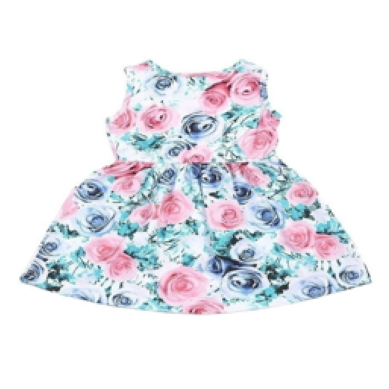

In [52]:
# показываем загруженое фото
plt.imshow(image)
plt.axis('off')
plt.show()

In [53]:
# Преобразуйте изображение в массив numpy и выполните предварительную обработку, аналогичную той, которую использовали для обучающего набора данных
image_array = np.array(image)
preprocessed_image = preprocess_input(image_array)

In [54]:
# предсказание для преобразованного изображения с помощью обученной модели.

predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

1/1 [==============================] - 0s 19ms/step


In [55]:
# ализируем результаты предсказания, чтобы определить класс, к которому относится изображение, и соответствующую точность.
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print("Predicted class:", predicted_class)
print("Confidence:", confidence)

Predicted class: dress casual
Confidence: 0.9092283


In [60]:
image_path = "shirt men_wb.jpg"
image = Image.open(image_path)
image = image.resize((244, 244))

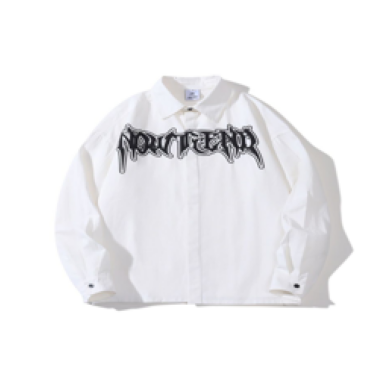

In [62]:
# показываем загруженое фото
plt.imshow(image)
plt.axis('off')
plt.show()

In [63]:
# Преобразуйте изображение в массив numpy и выполните предварительную обработку, аналогичную той, которую использовали для обучающего набора данных
image_array = np.array(image)
preprocessed_image = preprocess_input(image_array)

In [64]:
# предсказание для преобразованного изображения с помощью обученной модели.

predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

1/1 [==============================] - 0s 21ms/step


In [65]:
# ализируем результаты предсказания, чтобы определить класс, к которому относится изображение, и соответствующую точность.
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print("Predicted class:", predicted_class)
print("Confidence:", confidence)

Predicted class: sportswear women
Confidence: 0.9999999


In [66]:
image_path = "t-shirt women_wb.jpg"
image = Image.open(image_path)
image = image.resize((244, 244))

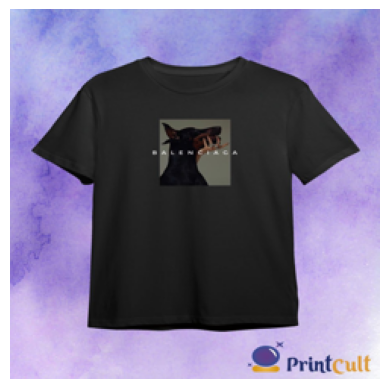

In [67]:
# показываем загруженое фото
plt.imshow(image)
plt.axis('off')
plt.show()

In [68]:
# Преобразуйте изображение в массив numpy и выполните предварительную обработку, аналогичную той, которую использовали для обучающего набора данных
image_array = np.array(image)
preprocessed_image = preprocess_input(image_array)

In [69]:
# предсказание для преобразованного изображения с помощью обученной модели.

predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

1/1 [==============================] - 0s 30ms/step


In [70]:
# ализируем результаты предсказания, чтобы определить класс, к которому относится изображение, и соответствующую точность.
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print("Predicted class:", predicted_class)
print("Confidence:", confidence)

Predicted class: t-shirt men
Confidence: 0.99078965
